### 05.2 神经网络法

<img src="https://microsoft.github.io/ai-edu/%E5%9F%BA%E7%A1%80%E6%95%99%E7%A8%8B/A2-%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%9F%BA%E6%9C%AC%E5%8E%9F%E7%90%86/%E7%AC%AC2%E6%AD%A5%20-%20%E7%BA%BF%E6%80%A7%E5%9B%9E%E5%BD%92/img/5/setup.png">  

#### 输入层

单个样本：

$$
x_1 =
\begin{pmatrix}
x_{11} & x_{12}
\end{pmatrix} = 
\begin{pmatrix}
10.06 & 60
\end{pmatrix} 
$$

$$
y_1 = \begin{pmatrix} 302.86 \end{pmatrix}
$$

一共有1000个样本，每个样本2个特征值，X就是一个$1000 \times 2$的矩阵：

$$
X = 
\begin{pmatrix} 
x_1 \\\\ x_2 \\\\ \vdots \\\\ x_{1000}
\end{pmatrix} =
\begin{pmatrix} 
x_{1,1} & x_{1,2} \\\\
x_{2,1} & x_{2,2} \\\\
\vdots & \vdots \\\\
x_{1000,1} & x_{1000,2}
\end{pmatrix}
$$

$$
Y =
\begin{pmatrix}
y_1 \\\\ y_2 \\\\ \vdots \\\\ y_{1000}
\end{pmatrix}=
\begin{pmatrix}
302.86 \\\\ 393.04 \\\\ \vdots \\\\ 450.59
\end{pmatrix}
$$


$x_1$ 表示第一个样本，$x_{1,1}$ 表示第一个样本的一个特征值，$y_1$ 是第一个样本的标签值。

#### 权重 $W$ 和 $B$

$$
W=
\begin{pmatrix}
w_1 \\\\ w_2
\end{pmatrix}
$$

$$B=(b)$$

#### 输出层

由于我们只想完成一个回归（拟合）任务，所以输出层只有一个神经元。由于是线性的，所以没有用激活函数。
$$
\begin{aligned}
Z&=
\begin{pmatrix}
  x_{11} & x_{12}
\end{pmatrix}
\begin{pmatrix}
  w_1 \\\\ w_2
\end{pmatrix}
+(b) \\\\
&=x_{11}w_1+x_{12}w_2+b
\end{aligned}
$$

写成矩阵形式：

$$Z = X\cdot W + B$$

#### 损失函数

因为是线性回归问题，所以损失函数使用均方差函数。

$$loss_i(W,B) = \frac{1}{2} (z_i-y_i)^2 \tag{1}$$

其中，$z_i$ 是样本预测值，$y_i$ 是样本的标签值。

### 5.2.2 反向传播

#### 单样本多特征计算

$$
\begin{aligned}  
\frac{\partial loss_i}{\partial W}&=
\begin{pmatrix}
  \frac{\partial loss_i}{\partial w_1} \\\\
  \frac{\partial loss_i}{\partial w_2}
\end{pmatrix} 
=\begin{pmatrix}
  (z_i-y_i) \cdot x_{i1} \\\\
  (z_i-y_i) \cdot x_{i2}
\end{pmatrix}  \\\\
&=\begin{pmatrix}
  x_{i1} \\\\
  x_{i2}
\end{pmatrix}
(z_i-y_i) 
=\begin{pmatrix}
  x_{i1} & x_{i2}
\end{pmatrix}^{\top}(z_i-y_i) \\\\
&=x_i^{\top}(z_i-y_i)
\end{aligned} \tag{5}
$$

$$
\frac{\partial loss_i}{\partial B}=z_i-y_i \tag{6}
$$

### 5.2.3 代码实现

我们先读取数据：

In [48]:
import numpy as np
from HelperClass.NeuralNet_1_1 import *
file_name = "ch05.npz"
reader = DataReader_1_1(file_name)
reader.ReadData()
print(reader.XRaw)

[[  6.20283041  65.        ]
 [  6.0339494   46.        ]
 [ 21.02827462  63.        ]
 ...
 [ 18.90574387  89.        ]
 [ 12.90042985  80.        ]
 [ 17.27501264 115.        ]]


我们可以看到，数据$X$的两个特征值都不在$[0,1]$之间，所以我们要对$X$做标准化处理：
###  标准化的常用方法

- Min-Max标准化（离差标准化），将数据映射到 $[0,1]$ 区间

$$x_{new}=\frac{x-x_{min}}{x_{max} - x_{min}} \tag{1}$$

- 平均值标准化，将数据映射到[-1,1]区间
   
$$x_{new} = \frac{x - \bar{x}}{x_{max} - x_{min}} \tag{2}$$

- 对数转换
$$x_{new}=\ln(x_i) \tag{3}$$

- 反正切转换
$$x_{new}=\frac{2}{\pi}\arctan(x_i) \tag{4}$$

- Z-Score法

把每个特征值中的所有数据，变成平均值为0，标准差为1的数据，最后为正态分布。Z-Score规范化（标准差标准化 / 零均值标准化，其中std是标准差）：

$$x_{new} = \frac{x_i - \bar{x}}{std} \tag{5}$$

- 中心化，平均值为0，无标准差要求
  
$$x_{new} = x_i - \bar{x} \tag{6}$$

- 比例法，要求数据全是正值

$$
x_{new} = \frac{x_k}{\sum_{i=1}^m{x_i}} \tag{7}
$$
这里使用Min-Max标准化，代码如下：

In [49]:
# 创建一个和X矩阵相同结构的零矩阵
X_new = np.zeros(reader.XRaw.shape)
# 获取X的特征值的数量2
num_feature = reader.XRaw.shape[1]
reader.X_norm = np.zeros((num_feature,2))
# 按列归一化,即所有样本的同一特征值分别做归一化
for i in range(num_feature):
    # 获取一个特征值的所有样本
    col_i = reader.XRaw[:,i]
    # 获取这个特征值的最大值和最小值
    max_value = np.max(col_i)
    min_value = np.min(col_i)
    # 最小值
    reader.X_norm[i,0] = min_value
    # 范围值
    reader.X_norm[i,1] = max_value - min_value 
    new_col = (col_i - reader.X_norm[i,0])/(reader.X_norm[i,1])
    X_new[:,i] = new_col
reader.XTrain = X_new
print(X_new)

[[0.21029881 0.3164557 ]
 [0.20184581 0.07594937]
 [0.95235654 0.29113924]
 ...
 [0.84611754 0.62025316]
 [0.54553365 0.50632911]
 [0.76449458 0.94936709]]


$X$的标准化完成，我们再检查一下Y值：

In [50]:
print(reader.YRaw)

[[381.59433917]
 [233.93210119]
 [310.94345076]
 [527.4484746 ]
 [341.58948234]
 [249.77916944]
 [331.98594409]
 [230.20237791]
 [250.44190777]
 [580.17123297]
 [270.4750714 ]
 [304.97360165]
 [441.36212649]
 [371.58178497]
 [400.37051796]
 [280.52637655]
 [266.56690844]
 [219.8645114 ]
 [621.87392592]
 [230.02286539]
 [457.24222825]
 [469.86368051]
 [258.73975201]
 [217.74709071]
 [208.21719379]
 [525.41470631]
 [478.57216909]
 [523.26743036]
 [332.99460117]
 [506.73297777]
 [341.12777489]
 [240.48704148]
 [260.86717333]
 [396.52088665]
 [343.21146005]
 [521.48112805]
 [495.01245411]
 [266.5764321 ]
 [250.61887138]
 [397.77086113]
 [224.23611045]
 [212.3669846 ]
 [396.10156616]
 [334.54622779]
 [488.62953125]
 [418.63579631]
 [479.04338219]
 [512.61633727]
 [404.48849252]
 [576.22461423]
 [385.56418585]
 [462.80835844]
 [532.21794236]
 [283.79821935]
 [434.34086635]
 [313.19947016]
 [256.67870951]
 [241.89640703]
 [385.91984369]
 [566.77375301]
 [556.47855421]
 [531.9516286 ]
 [580.50

因为$Y$ 值不在 $[0,1]$ 之间时，也要做标准化：

In [51]:
reader.Y_norm = np.zeros((1,2))
max_value = np.max(reader.YRaw)
min_value = np.min(reader.YRaw)
reader.Y_norm[0, 0] = min_value 
reader.Y_norm[0, 1] = max_value - min_value 
y_new = (reader.YRaw - min_value) / reader.Y_norm[0, 1]
reader.YTrain = y_new
print(y_new)

[[0.40711489]
 [0.10777675]
 [0.26389272]
 [0.70278768]
 [0.32601779]
 [0.13990163]
 [0.30654967]
 [0.10021592]
 [0.14124512]
 [0.80966627]
 [0.18185598]
 [0.25179075]
 [0.52827504]
 [0.38681763]
 [0.44517761]
 [0.20223179]
 [0.17393342]
 [0.07925919]
 [0.8942052 ]
 [0.09985202]
 [0.56046688]
 [0.58605286]
 [0.15806635]
 [0.07496679]
 [0.05564796]
 [0.69866486]
 [0.60370654]
 [0.69431194]
 [0.3085944 ]
 [0.66079361]
 [0.32508182]
 [0.1210648 ]
 [0.16237902]
 [0.43737371]
 [0.32930583]
 [0.69069079]
 [0.63703398]
 [0.17395273]
 [0.14160386]
 [0.43990763]
 [0.08812121]
 [0.06406034]
 [0.43652367]
 [0.31173983]
 [0.62409464]
 [0.48220464]
 [0.60466178]
 [0.67272025]
 [0.45352549]
 [0.80166576]
 [0.41516249]
 [0.57175044]
 [0.71245626]
 [0.20886441]
 [0.51404167]
 [0.26846608]
 [0.15388825]
 [0.12392184]
 [0.41588347]
 [0.78250715]
 [0.76163692]
 [0.71191639]
 [0.81034681]
 [0.81809386]
 [0.57398203]
 [0.4131423 ]
 [0.65340036]
 [0.88069868]
 [0.53665513]
 [0.40448287]
 [0.61537023]
 [0.88

之后我们就可以训练了，学习率为0.01，最大迭代次数为200，批数为10，误差为1e-5

epoch=0
0 9 0.10914672861044875 [[0.02188536]
 [0.0273818 ]] [[0.04356693]]
0 19 0.08632388945525386 [[0.04015441]
 [0.05064325]] [[0.08036462]]
0 29 0.06902874565740529 [[0.05390834]
 [0.07275602]] [[0.11257935]]
0 39 0.05486936724788705 [[0.06776329]
 [0.09436287]] [[0.14266562]]
0 49 0.04690887915089434 [[0.07610985]
 [0.10841511]] [[0.16245945]]
0 59 0.03941451956751871 [[0.08510858]
 [0.12359864]] [[0.18373402]]
0 69 0.033854840171202966 [[0.0918142 ]
 [0.13843027]] [[0.20104327]]
0 79 0.02990005559043574 [[0.09763199]
 [0.15064693]] [[0.21497376]]
0 89 0.026963363164529065 [[0.10207931]
 [0.16100069]] [[0.22696477]]
0 99 0.023782839165786194 [[0.10907169]
 [0.17420618]] [[0.24163795]]
epoch=1
1 9 0.02252864709162618 [[0.11170796]
 [0.18125731]] [[0.24747489]]
1 19 0.021104746808148386 [[0.11316729]
 [0.19059523]] [[0.25492595]]
1 29 0.01972717727522959 [[0.1150748]
 [0.2006066]] [[0.26350539]]
1 39 0.01898636504701969 [[0.11467138]
 [0.20767165]] [[0.26768134]]
1 49 0.01824206494

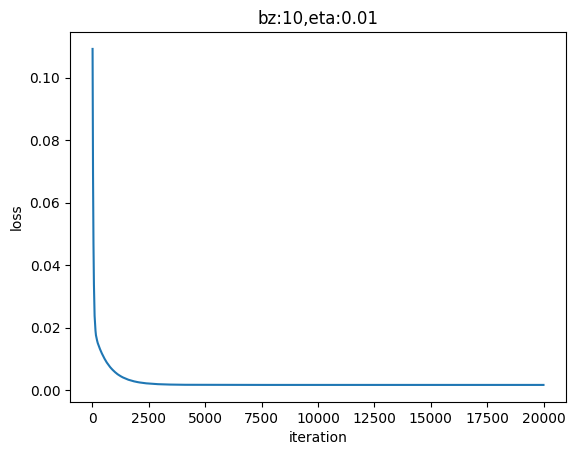

W= [[-0.08578007]
 [ 0.79790423]]
B= [[0.13225259]]


In [52]:

hp = HyperParameters_1_0(2, 1, eta=0.01, max_epoch=200, batch_size=10, eps=1e-5)
net = NeuralNet_1_1(hp)
net.train(reader, checkpoint=0.1)
# inference


迭代很成功，但是得出的结果受标准化的影响不是真实值，所以我们对得出来的预测结果做关于$Y$的反标准化，反标准化的公式为：
$$y = y_{new}(y_{max}-y_{min})+y_{min} \tag{3}$$

In [53]:
x1 = 15
x2 = 93
x = np.array([x1,x2]).reshape(1,2)

X_new = np.zeros(x.shape)
n = x.shape[1]
for i in range(n):
    col_i = x[:,i]
    X_new[:,i] = (col_i - reader.X_norm[i,0]) / reader.X_norm[i,1]

z = net.inference(X_new)
print("z=", z)
Z_true = z * reader.Y_norm[0,1] + reader.Y_norm[0,0]
print("Z_true=", Z_true)

z= [[0.61174492]]
Z_true= [[482.53746457]]


预测结果合理，可视化为：

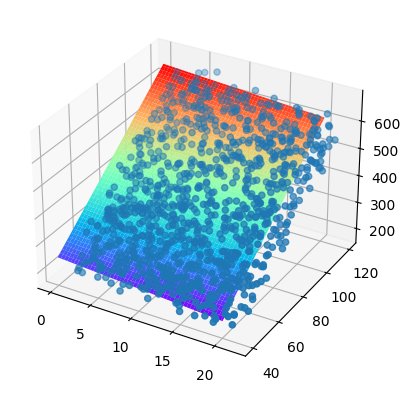

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reader.XRaw[:,0],reader.XRaw[:,1],reader.YRaw)
u = np.linspace(0, 20, 100)
v = np.linspace(40, 120, 100)
XM, YM = np.meshgrid(u, v)
R = np.zeros((len(u), len(v)))
for i in range(len(u)):
        for j in range(len(v)):
            x = np.array([u[j],v[i]]).reshape(1,2)
            x_new = reader.NormalizePredicateData(x)
            z = net.inference(x_new)
            R[i,j] = z * reader.Y_norm[0,1] + reader.Y_norm[0,0]
ax.plot_surface(XM, YM, R, cmap='rainbow')
plt.show()